In [3]:
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd

from google.colab import drive
#drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
import keras
import pandas as pd

import os
import requests

import shutil
import random
from math import floor
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Dense

import tensorflow as tf
import tensorflow.keras
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

In [4]:
#!pip install q keras==3.2.1

In [6]:
!unzip "/content/drive/My Drive/Fac/DL2/new_dataset_arrays.zip" -d "/content"

Archive:  /content/drive/My Drive/Fac/DL2/new_dataset_arrays.zip
  inflating: /content/new_dataset_arrays.pkl  


In [7]:

pickle_file_path = '/content/new_dataset_arrays.pkl'
df = pd.read_pickle(pickle_file_path)

In [8]:
df.head(1)

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum,filename,image_path,image_array_sq,is_grayscale
0,5e82a45bc5d78bd24ae9202d194423f8,3,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...,minocycline-pigmentation1.jpg,C:\Users\afspf\Documents\FAC\2nd semester\DL\P...,"[[[169, 180, 190], [171, 181, 193], [174, 182,...",False


In [9]:
dataset = df.copy()

In [10]:
label_encoder = LabelEncoder()
dataset['label_encoded'] = label_encoder.fit_transform(dataset['label'])

X = np.stack(dataset['image_array_sq'].values)
y = dataset['label_encoded'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42, stratify=y_temp)

y_train_encoded = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_val_encoded = to_categorical(y_val, num_classes=len(label_encoder.classes_))
y_test_encoded = to_categorical(y_test, num_classes=len(label_encoder.classes_))

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}


In [11]:
dataset.head(1)

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum,filename,image_path,image_array_sq,is_grayscale,label_encoded
0,5e82a45bc5d78bd24ae9202d194423f8,3,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...,minocycline-pigmentation1.jpg,C:\Users\afspf\Documents\FAC\2nd semester\DL\P...,"[[[169, 180, 190], [171, 181, 193], [174, 182,...",False,20


In [12]:
from keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input

X_train_img = preprocess_input(X_train)
X_val_img = preprocess_input(X_val)
X_test_img = preprocess_input(X_test)

In [13]:

from tensorflow.keras import applications
IMG_SHAPE = (300,300, 3)


base_model = applications.EfficientNetB3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
for layer in base_model.layers[:-2]:
    layer.trainable = False

In [15]:
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import F1Score


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_1 = layers.Dropout(0.5)  # Dropout after the first dense layer
dense_layer_2 = layers.Dense(256, activation='relu')
dropout_2 = layers.Dropout(0.5)  # Dropout after the second dense layer
dense_layer_3 = layers.Dense(128, activation='relu')
dropout_3 = layers.Dropout(0.5)  # Dropout after the third dense layer
prediction_layer = layers.Dense(114, activation='softmax')

model2 = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_1,  # Dropout after the first dense layer
    dense_layer_2,
    dropout_2,  # Dropout after the second dense layer
#    dense_layer_3,
#    dropout_3,  # Dropout after the third dense layer
    prediction_layer
])

base_learning_rate = 0.00001
model2.compile(optimizer=optimizers.RMSprop(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(average='weighted', name = "f1_score")])

After the training stops by EarlyStopping callback, the current model may not be the best model with the highest/lowest monitored quantity. As a result a new argument, restore_best_weights, has been introduced in Keras 2.2.3 release for EarlyStopping callback if you would like to restore the best weights:

restore_best_weights: whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', patience=2,  restore_best_weights=True)

In [17]:
history = model2.fit(
    x=X_train_img,
    y=y_train_encoded,
    epochs=30,
    validation_data=(X_val_img, y_val_encoded),
    class_weight=class_weights_dict,
    batch_size = 64,
    verbose=1,
    shuffle=True,
    callbacks=[es])

Epoch 1/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 203s 612ms/step - accuracy: 0.0087 - f1_score: 0.0084 - loss: 5.2004 - val_accuracy: 0.0359 - val_f1_score: 0.0287 - val_loss: 4.6586
Epoch 2/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 36s 184ms/step - accuracy: 0.0253 - f1_score: 0.0228 - loss: 4.7075 - val_accuracy: 0.0646 - val_f1_score: 0.0485 - val_loss: 4.5706
Epoch 3/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 36s 184ms/step - accuracy: 0.0351 - f1_score: 0.0319 - loss: 4.5626 - val_accuracy: 0.0905 - val_f1_score: 0.0701 - val_loss: 4.4737
Epoch 4/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 36s 184ms/step - accuracy: 0.0555 - f1_score: 0.0476 - loss: 4.4056 - val_accuracy: 0.1127 - val_f1_score: 0.0904 - val_loss: 4.3756
Epoch 5/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 36s 184ms/step - accuracy: 0.0675 - f1_score: 0.0582 - loss: 4.2651 - val_accuracy: 0.1369 - val_f1_score: 0.1151 - val_loss: 4.2692
Epoch 6/30
194/194 ━━━━━━━━━━━━━━━━━━━━ 36s 184ms/step - accuracy: 0.0910 - f1_score: 0.0825 - loss: 4.1554 - val_accuracy: 0.1482 - v

In [18]:
print(model2.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 10, 10, 1536)        │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 153600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      78,643,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 114)                 │          29,298 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,395,285 (642.38 MB)

 Trainable params: 78,807,410 (300.63 MB)

 Non-trainable params: 10,780,463 (41.12 MB)

 Optimizer params: 78,807,412 (300.63 MB)

None


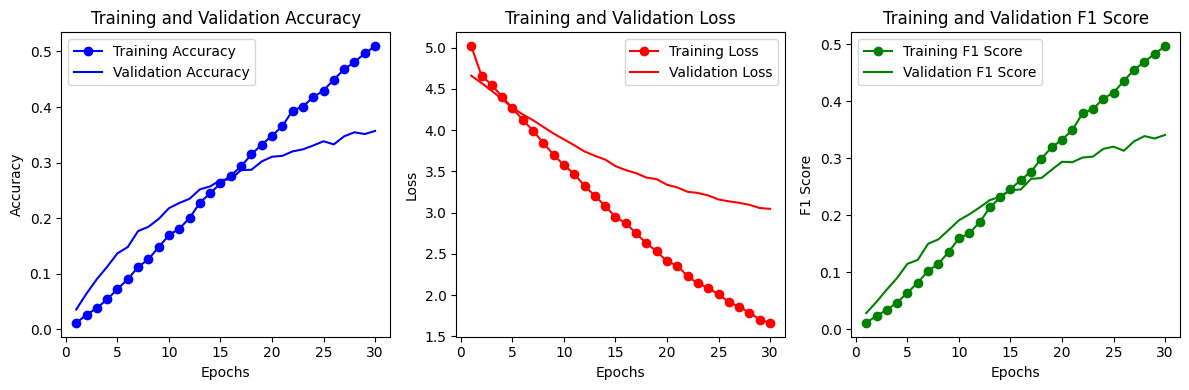

In [24]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1_score = history.history['f1_score']  
val_f1_score = history.history['val_f1_score']  

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, f1_score, 'go-', label='Training F1 Score')
plt.plot(epochs, val_f1_score, 'g-', label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
predictions = model2.predict(X_test_img)


52/52 ━━━━━━━━━━━━━━━━━━━━ 44s 416ms/step


In [26]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test_encoded, axis=1)


In [31]:
from sklearn.metrics import f1_score

f1 = f1_score(true_classes, predicted_classes, average='weighted')
print("Weighted F1 Score : ", f1)


Weighted F1 Score :  0.3473166467760448


In [36]:
f1 = f1_score(true_classes, predicted_classes, average='micro')
print("Micro F1 Score : ", f1)

Micro F1 Score :  0.35857056329497267


In [35]:
f1 = f1_score(true_classes, predicted_classes, average='macro')
print("Macro F1 Score : ", f1)

Macro F1 Score :  0.3437022303395223


In [30]:
final_val_loss = history.history['val_loss'][-1]
print("Final validation loss:", final_val_loss)

Final validation loss: 3.0458004474639893


In [29]:
from sklearn.metrics import classification_report

class_names = label_encoder.inverse_transform(np.unique(y_test))
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)


                                                       precision    recall  f1-score   support

                                 acanthosis nigricans       0.29      0.44      0.35         9
                                                 acne       0.25      0.26      0.26        19
                                        acne vulgaris       0.43      0.82      0.57        34
acquired autoimmune bullous diseaseherpes gestationis       0.20      0.17      0.18         6
                         acrodermatitis enteropathica       0.40      0.44      0.42         9
                                    actinic keratosis       0.12      0.11      0.12        18
                          allergic contact dermatitis       0.36      0.09      0.15        43
                                        aplasia cutis       0.33      0.57      0.42         7
                                 basal cell carcinoma       0.40      0.36      0.38        47
                     basal cell carcinoma morphei

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
